With updated parameters (delta and temperature T)

In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator
from pyscf import gto, scf, ao2mo


def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

/Users/tdao/opt/anaconda3/envs/pyqt-2/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Setting h5py.default_file_mode is deprecated. 'r' (read-only) is the default from h5py 3.0.
  h5py.get_config().default_file_mode = 'r'


In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
import pandas as pd


def get_qubit_op(coordinates):

    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', n_shots=128):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend, shots=n_shots)
        optimizer = COBYLA(maxiter=500, tol=0.0001)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = SLSQP(maxiter=5)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)


    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    return vqe_ground, min_eng

    
    


In [3]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli


def get_psi_0(coordinates, simulator='qasm', n_shots=128):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator, n_shots=n_shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm', n_shots=2096):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator=simulator, n_shots=n_shots)
        
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=n_shots)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
       
        #get the expectation value <psi_0|O|psi_0>¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        f = sampler.eval().real + rep_eng_plus - rep_eng_minus
        
        forces.append(f*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces



In [4]:


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, n_shots = 2096):

    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=n_shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)    
    psi_0 = get_psi_0(coordinates, simulator = simulator, n_shots=n_shots)

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    
    
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I)
        
       
        op = - (qubit_op_plus - qubit_op_minus)
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:
            
            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops.append(op)
        force_op_coeffs.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    
    if PauliSet == None:
        
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    
    # Now we calculate the expectation values of all the relevant PauliOps
    
    exp_dict = {} # dictionary with relevant expectation values
    
    for pauli_string in pauli_op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        
        exp_dict[pauli_string] = E
            
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
                forces[i] += coeff.real*exp_dict[pauli_op]
                
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
    
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()
            
            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
            #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]
            
            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]            
  
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2/n_shots



def lanczos_force_and_cov(coordinates, d=-0.4, simulator = 'qasm', PauliSet = None, n_shots = 2096):

    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=n_shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)    
    psi_0 = get_psi_0(coordinates, simulator = simulator, n_shots=n_shots)

    forces = np.zeros(num_coord)
    force_ops_original = []
    force_op_coeffs_lanczos = [] # array with dictionaries containing Pauli coefficients
        

    #get qubit operators coresponding to H (hamiltonian for atomic distances R)
    (H_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    rep_eng = problem.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    H_op = H_op + rep_eng*(I^I)
    lanczos_trans = (H_op-d*(I^I)).reduce()      
    N2_op_lanczos=(lanczos_trans@lanczos_trans).reduce()
    
    #construct dict
    lanczos_dict = {}
    for (PauliString,coeff) in N2_op_lanczos.primitive.to_list():
        if PauliString in lanczos_dict:
            lanczos_dict[PauliString] += coeff
        else:
            lanczos_dict[PauliString] = coeff
             
        
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])


        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I)
        
        
        op_original = - (qubit_op_plus - qubit_op_minus)
        op_lanczos = lanczos_trans@op_original@lanczos_trans
        
        op_list = op_lanczos.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:
            
            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops_original.append(op_original)
        force_op_coeffs_lanczos.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op_original


    if PauliSet == None:
        
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate
        
        for PauliString, coeff in lanczos_dict.items():
            pauli_op_set.add(PauliString) 

        for PauliString,coeff in force_op_coeffs_lanczos[0].items():
            pauli_op_set.add(PauliString)

            #to get set of necessary PauliOp products:
            P_prod_original = P1@P1
            P_prod_lanczos = lanczos_trans@P_prod_original@lanczos_trans
            P_list = P_prod_lanczos.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet

    # Now we calculate the expectation values of all the relevant PauliOps

    exp_dict = {} # dictionary with relevant expectation values

    for pauli_string in pauli_op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        
        exp_dict[pauli_string] = E
        
    N2_lanczos=0
    for pauli_op,coeff in lanczos_dict.items():
        N2_lanczos += coeff.real*exp_dict[pauli_op]

    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs_lanczos[i].items():
                forces[i] += coeff.real*exp_dict[pauli_op]
    forces/=N2_lanczos

    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 

    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij_original = force_ops_original[i]@force_ops_original[j]
            Pij_lanczos = lanczos_trans@Pij_original@lanczos_trans
            Pij_list = Pij_lanczos.primitive.to_list()
            
            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
            #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]
            
            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    COV/=N2_lanczos            

    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2/n_shots



In [5]:
from tqdm import tqdm #to show progress

femto = 1.0e-15
angst = 1.0e-10
mass_0 = 1.67e-27
#mass of particle2 (H)
mass_1 = 1.67e-27
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init_0 = 0
v_init_1 = 0

v_init = np.array([v_init_0,v_init_1])

#initial positions of atoms
init_pos = [0, 0.6]

#integrator timesteps
tf = 300
times = np.arange(0*femto, tf*femto, dt)
#coordinate array
coords = [init_pos]
coords_L = [init_pos]
force = []
force_L = []
force_exact = []

#k_B*T in Joule
k_B = 1.38065e-23
T = 420
k_T = k_B*T
#delta factor
delta = 0.1*dt

# Lanczos parameter 
d_Lanczos = -0.05

#hold v_next
v_next = None
v_next_L = None

for time in tqdm(times, desc='Progress: '):
    r = coords[-1]
    
    (forces,COV) = calc_force_and_cov(coords[-1], n_shots=128)
    f0 = forces[0]
    f1 = forces[1]
    (forces_L,COV_L) = lanczos_force_and_cov(coords[-1], d=d_Lanczos, n_shots=128)
    f0_L = forces_L[0]
    f1_L = forces_L[1]
    (f0_exact, f1_exact) = calc_forces(coords[-1], simulator='exact')
    force.append(f0)
    force_L.append(f0_L)
    force_exact.append(-f0_exact)
    
    if time == 0:

        v_next   = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV  ,v_init)*dt + np.concatenate((f0/mass_0,  f1/mass_1),  axis=None)*dt
        v_next_L = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV_L,v_init)*dt + np.concatenate((f0_L/mass_0,f1_L/mass_1),axis=None)*dt
        
    else:

        v_next   += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,  v_next)*dt + np.concatenate((f0/mass_0,  f1/mass_1),  axis=None)*dt
        v_next_L += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV_L,v_next)*dt + np.concatenate((f0_L/mass_0,f1_L/mass_1),axis=None)*dt

    r_next   = (np.array(r)*angst + dt*v_next  )/angst
    r_next_L = (np.array(r)*angst + dt*v_next_L)/angst

    coords.append(  [r_next[0],   r_next[1]  ])
    coords_L.append([r_next_L[0], r_next_L[1]])


Progress:   0%|          | 0/1500 [00:00<?, ?it/s]/Users/tdao/opt/anaconda3/envs/pyqt-2/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()
Progress: 100%|██████████| 1500/1500 [2:10:19<00:00,  5.21s/it] 


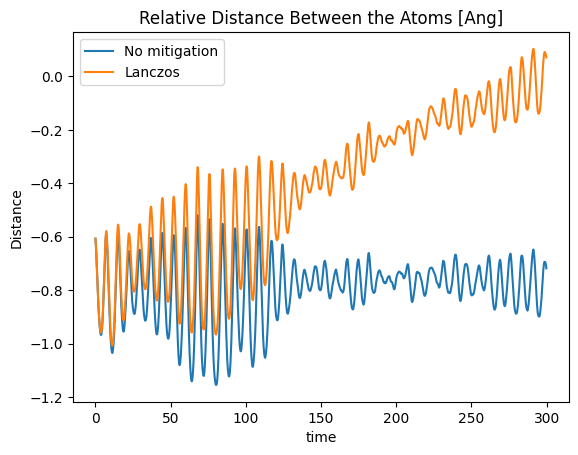

In [9]:
coords_np   = np.array(coords)
coords_np_L = np.array(coords_L)
rel_dist   = coords_np[1:,0]   - coords_np[1:,1]
rel_dist_L = coords_np_L[1:,0] - coords_np_L[1:,1]
plt.plot(times/femto,rel_dist,   label="No mitigation")
plt.plot(times/femto,rel_dist_L, label="Lanczos")
plt.title('Relative Distance Between the Atoms [Ang]')
plt.xlabel("time")
plt.ylabel("Distance")
plt.legend()
plt.show()

In [7]:
import pandas as pd
pd.DataFrame({"time":times,"distance":rel_dist,"distance_lanczos":rel_dist_L}).to_csv(f'data/coords_tf{tf}_d{d_Lanczos}_Lanczos.csv', index=False)

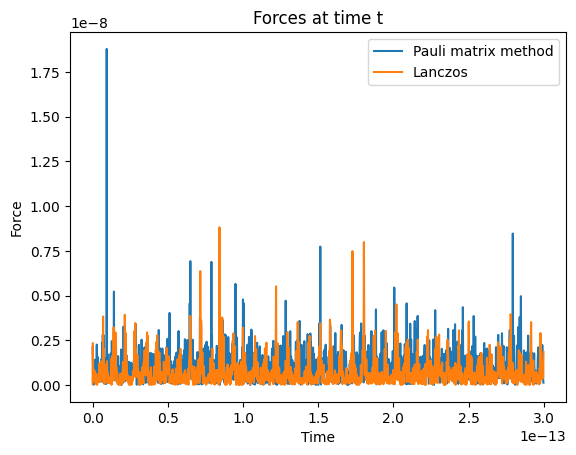

In [8]:
plt.plot(times,abs(np.array(force)-np.array(force_exact)),   label = 'Pauli matrix method')
plt.plot(times,abs(np.array(force_L)-np.array(force_exact)), label = 'Lanczos')
#plt.plot(times,force_exact, label = 'Exact')
plt.title('Forces at time t')
plt.xlabel('Time')
plt.ylabel('Force')
plt.legend()
plt.show()

In [9]:

def exact_energy(coordinates):
    molecule = gto.M(
        # Coordinates in Angstrom
        atom=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        basis='sto3g',
        spin=0,  # = 2*spin + 1
        charge=0,
    )

    # Harttree-Fock calculations
    rhf = scf.RHF(molecule)
    rhf.kernel()

    return rhf.e_tot
    

def lanczos_min_eng(coordinates, d=-0.4, simulator = 'qasm', PauliSet = None, n_shots = 2096):

    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=n_shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)    
    psi_0 = get_psi_0(coordinates, simulator = simulator, n_shots=n_shots)

    forces = np.zeros(num_coord)
    force_ops_original = []
    force_op_coeffs_lanczos = [] # array with dictionaries containing Pauli coefficients
        

    #get qubit operators coresponding to H (hamiltonian for atomic distances R)
    (H_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    rep_eng = problem.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    H_op = H_op + rep_eng*(I^I)
    lanczos_trans = (H_op-d*(I^I)).reduce()      
    N2_op_lanczos=(lanczos_trans@lanczos_trans).reduce()
    
    #construct dict
    lanczos_dict = {}
    for (PauliString,coeff) in N2_op_lanczos.primitive.to_list():
        if PauliString in lanczos_dict:
            lanczos_dict[PauliString] += coeff
        else:
            lanczos_dict[PauliString] = coeff
             
    
    H_op_lanczos = lanczos_trans@H_op@lanczos_trans
    op_list = H_op_lanczos.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
     
    #construct dict from list
    H_op_dict = {}
    for (PauliString,coeff) in op_list:
        if PauliString in H_op_dict:
            H_op_dict[PauliString] += coeff
        else:
            H_op_dict[PauliString] = coeff
            
    pauli_op_set = {'II'} #Could not initialize empty set for some reason
    # construct set of PauliOp products that we need to calculate
    
    for PauliString, coeff in lanczos_dict.items():
        pauli_op_set.add(PauliString) 

    for PauliString,coeff in H_op_dict.items():
        pauli_op_set.add(PauliString)
    
    # Now we calculate the expectation values of all the relevant PauliOps

    exp_dict = {} # dictionary with relevant expectation values

    for pauli_string in pauli_op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        
        exp_dict[pauli_string] = E
        
        
    N2_lanczos=0
    for pauli_op,coeff in lanczos_dict.items():
        N2_lanczos += coeff.real*exp_dict[pauli_op]

    min_eng = 0
    for pauli_op,coeff in H_op_dict.items():
        min_eng += coeff.real*exp_dict[pauli_op]
    min_eng/=N2_lanczos

    return min_eng


In [10]:
exact_energy([0.0, 0.6])
lanczos_min_eng([0.0, 0.6])

converged SCF energy = -1.1011282422677


-1.1202955736039686

In [11]:
r_list = [0.6, 0.7, 0.9]
d_list = np.linspace(-1.5, -0.1, 20)
error = np.zeros((len(r_list), len(d_list)))
for i,r in enumerate(r_list):
    pos = [0.0, r]
    min_eng_exact = exact_energy(pos)
    for j,d in enumerate(d_list):
        error[i,j]=abs(lanczos_min_eng([0.0, r], d=d, n_shots=8192)-min_eng_exact)
        

converged SCF energy = -1.1011282422677
converged SCF energy = -1.11734903499028
converged SCF energy = -1.09191404102006


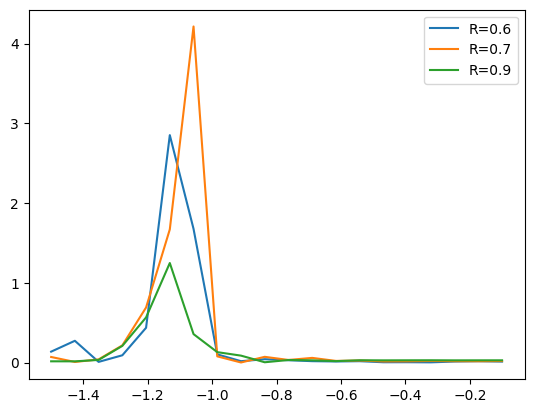

In [12]:
for i,r in enumerate(r_list):
    plt.plot(d_list,error[i], label=f'R={r}')
plt.legend()
plt.show()

In [13]:
from qiskit_nature.operators.second_quantization import FermionicOp
ecore = 3.14
qubit_ecore = ecore*(I^I)
print(qubit_ecore)

ferm_ecore = ecore*FermionicOp("II")
print(ferm_ecore)

mapper = ParityMapper()  # Set Mapper
converter = QubitConverter(mapper,two_qubit_reduction=True)
reducer = TwoQubitReduction(num_particles=2)
qubit_op = converter.convert(ferm_ecore)
#qubit_op = reducer.convert(qubit_op)
print(qubit_op)


3.14 * II
(3.14+0j)
3.14 * II
